In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast, os
import bambi as bmb
import pymc as pm
import arviz as az
import scipy.stats as stat

# Function to clean the data files

#### For each data file this function does the following:
1. Drops irrelevant columns
2. Computes accuracies (accurate if all correct keys pressed on the first try)
3. Label Node types: Boundary vs non boundary
4. Label transition types: Cross cluster or within cluster
4. Label other relevant conditions like walk length, number of keypresses, etc. 

In [46]:
def clean_data(filename):
    try:
        data = pd.read_csv('data/' + filename)
        # Drop instruction rows by dropping rows with missing data in column: 'blocks.thisRepN'
        data = data.dropna(subset=['blocks.thisRepN']).reset_index(drop=True)

        if len(data) < 1400:
            raise TypeError('Incomplete Data')

        #Compute accuracy as True if number of response values are the same as number of stim values
        # print(data['stim'])
        data['accuracy'] = [True if (len(ast.literal_eval(data['stim'][i])) == len(ast.literal_eval(data['key_resp.rt'][i]))) else False for i in range(len(data))]


        data['node_type'] = ['Boundary' if data['node idx'][i] in [0, 4, 5, 9, 10, 14] else 'Non Boundary' for i in range(len(data))]

        data['rt'] = [np.mean(ast.literal_eval(data['key_resp.rt'][i])) if data['accuracy'][i] else np.NaN for i in range(len(data))]
        data['transition_type'] = ['cross cluster' if (data['node_type'] == 'Boundary')[i] & (data['node_type'].shift() == 'Boundary')[i] else 'within cluster' for i in range(len(data))]

        if data['participant'][0]%4 == 0:
            data['walk_length'] = 0
        elif data['participant'][0]%4 == 1:
            data['walk_length'] = 3
        elif data['participant'][0]%4 == 2:
            data['walk_length'] = 6
        else:
            data['walk_length'] = 1400

        data['trial'] = np.arange(len(data))
    except:
        return None
    data['num_keypress'] = [len(ast.literal_eval(data['stim'][i])) for i in range(len(data))]

    return data[['participant', 'trial', 'blocks.thisRepN', 'accuracy', 'walk_length', 'node_type', 'transition_type', 'rt', 'stim', 'num_keypress']]


# Read the data files

In [47]:
data_files = []
for f in os.listdir('data/'):
    if (f.startswith('30') & f.endswith('csv')):
        data_files.append(f)

# Clean the data files into a single large dataframe

1. Label Trials, conditions, etc. 
2. Combine relevant columns of extracted data files 
3. Specify outliers and remove them


In [48]:
df_clean = pd.concat([clean_data(f) for f in data_files]).reset_index(drop = True)
df_clean['reset'] = 'False'
df_clean.loc[df_clean['trial'].values%(df_clean['walk_length'].values+1) == 0, 'reset'] = 'True'



df_clean_rt_outlier = df_clean[np.abs(stat.zscore(df_clean['rt'], nan_policy='omit')) < 3]
df_clean_rt_outlier['node_transition_type'] = df_clean_rt_outlier['node_type'] + ' ' + df_clean_rt_outlier['transition_type']

df_clean_participant = df_clean_rt_outlier.groupby(['participant', 'blocks.thisRepN', 'walk_length', 'node_type', 'transition_type', 'num_keypress']).median().reset_index()

df_clean_rt_outlier['walk_length'] = df_clean_rt_outlier.walk_length.astype('str')
# df_clean = df_clean.loc[stat.zscore(df_clean['rt']) < 3].reset_index()

C:\Users\tejas\AppData\Local\Temp\ipykernel_26264\4282757054.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_rt_outlier['node_transition_type'] = df_clean_rt_outlier['node_type'] + ' ' + df_clean_rt_outlier['transition_type']
C:\Users\tejas\AppData\Local\Temp\ipykernel_26264\4282757054.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_clean_participant = df_clean_rt_outlier.groupby(['participant', 'blocks.thisRepN', 'walk_length', 'node_type', 'transition_type', 'num_keypress']).median().reset_index()
C:\Users\tejas\AppData\Local\Temp\i

In [56]:
df_clean_rt_outlier

,participant,trial,blocks.thisRepN,accuracy,walk_length,node_type,transition_type,rt,stim,num_keypress,reset,node_transition_type
0,3000.0,0,0.0,True,0,Boundary,within cluster,1.367459,"('l', 'space')",2,True,Boundary within cluster
2,3000.0,2,0.0,True,0,Boundary,within cluster,1.377622,"('j', 'space')",2,True,Boundary within cluster
3,3000.0,3,0.0,True,0,Non Boundary,within cluster,1.171814,"('j', 'k')",2,True,Non Boundary within cluster
4,3000.0,4,0.0,True,0,Boundary,within cluster,1.230127,"('l', 'space')",2,True,Boundary within cluster
5,3000.0,5,0.0,True,0,Boundary,cross cluster,0.726496,"('l', 'space')",2,True,Boundary cross cluster
...,...,...,...,...,...,...,...,...,...,...,...,...
124593,3099.0,1393,6.0,True,1400,Non Boundary,within cluster,1.021854,"('j', 'space')",2,False,Non Boundary within cluster
124594,3099.0,1394,6.0,True,1400,Boundary,within cluster,0.658679,"('k',)",1,False,Boundary within cluster
124595,3099.0,1395,6.0,True,1400,Non Boundary,within cluster,1.424606,"('h', 'k')",2,False,Non Boundary within cluster
124598,3099.0,1398,6.0,True,1400,Boundary,within cluster,0.701917,"('k',)",1,False,Boundary within cluster


# Plot Accuracies

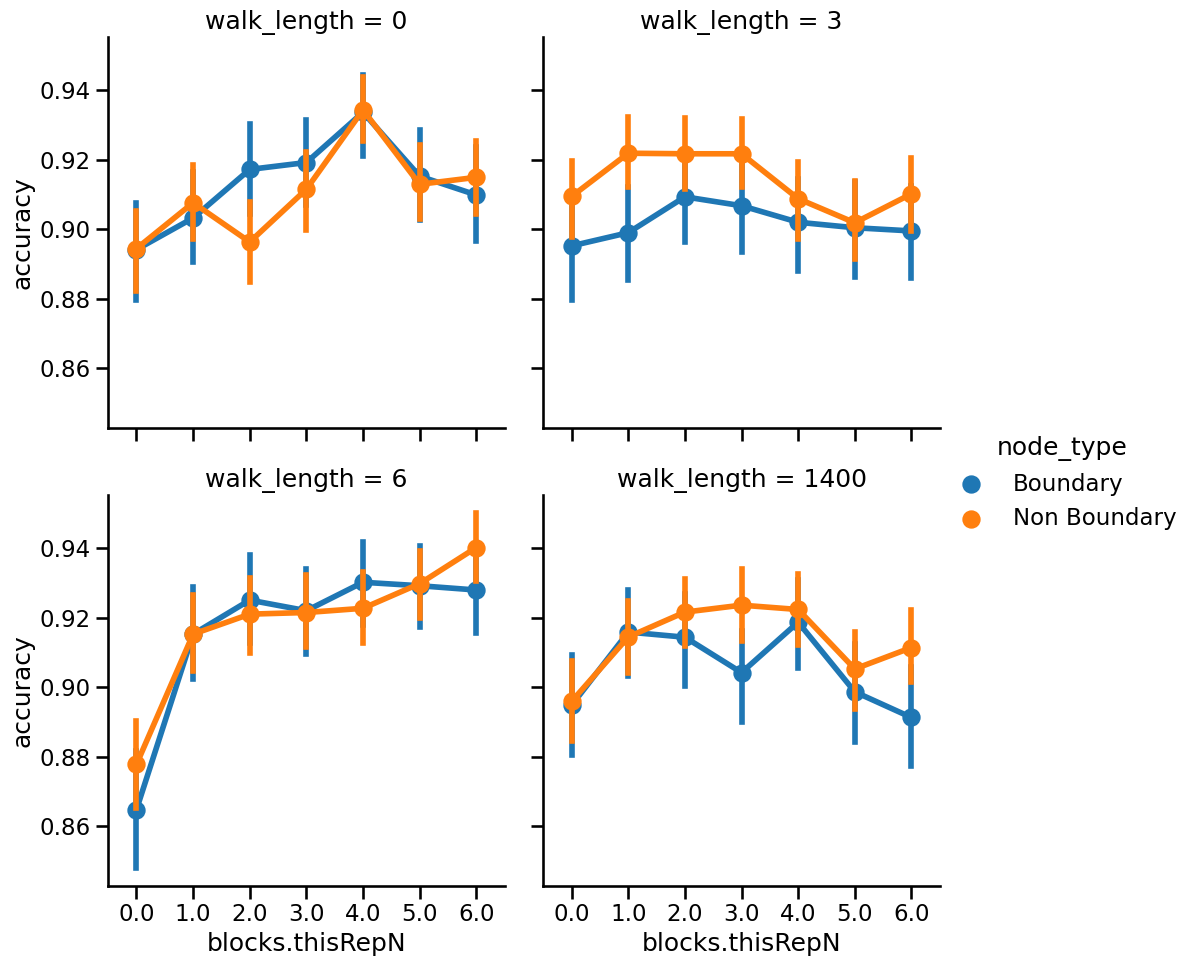

In [49]:
sns.set_context('talk')
sns.catplot(y = 'accuracy', 
            x = 'blocks.thisRepN', col = 'walk_length', hue = 'node_type', col_wrap=2,
            kind = 'point',
            data=df_clean)


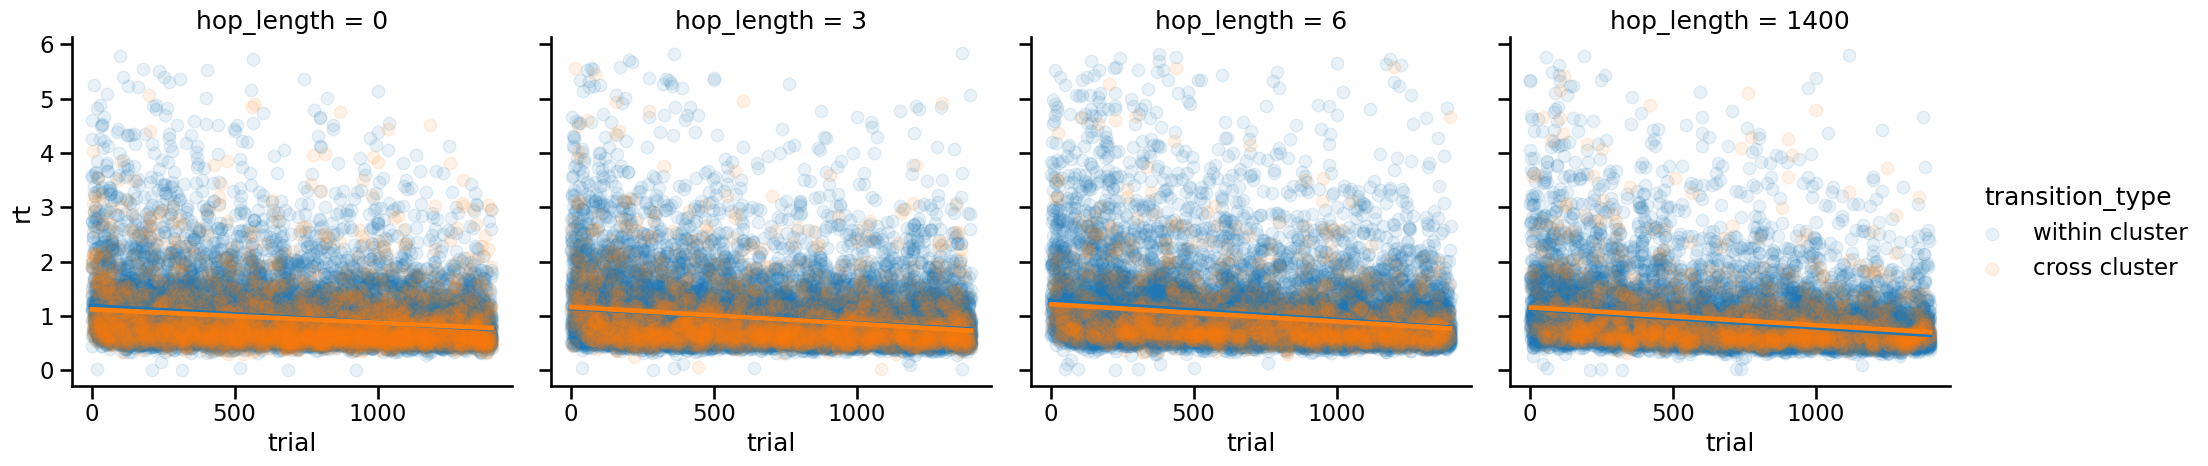

In [6]:
sns.lmplot(y = 'rt', 
            x = 'trial', col = 'walk_length', hue = 'transition_type',
            data=df_clean_rt_outlier, scatter_kws={'alpha': 0.1})


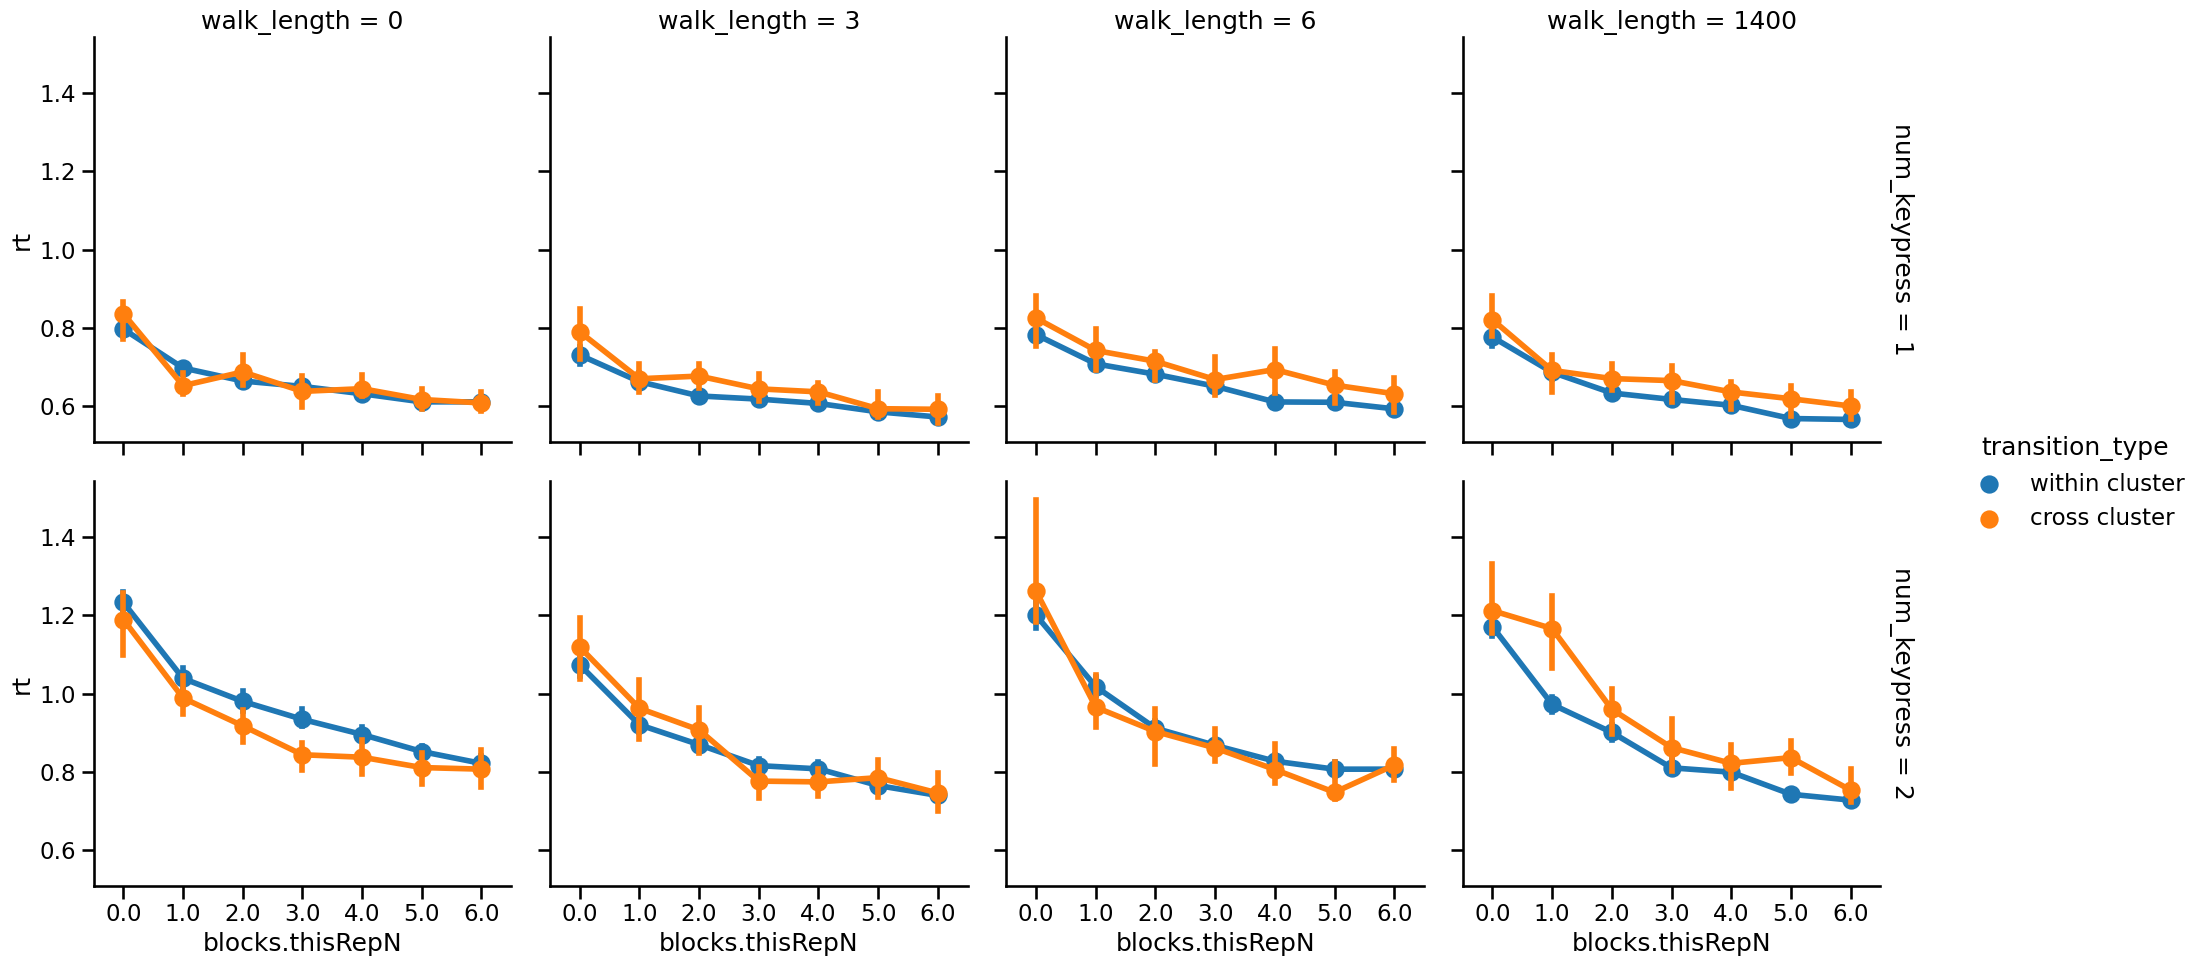

In [52]:
sns.catplot(y = 'rt', 
            x = 'blocks.thisRepN', col = 'walk_length', hue = 'transition_type', row = 'num_keypress',
            kind = 'point', estimator='median', margin_titles=True,
            data=df_clean_rt_outlier)


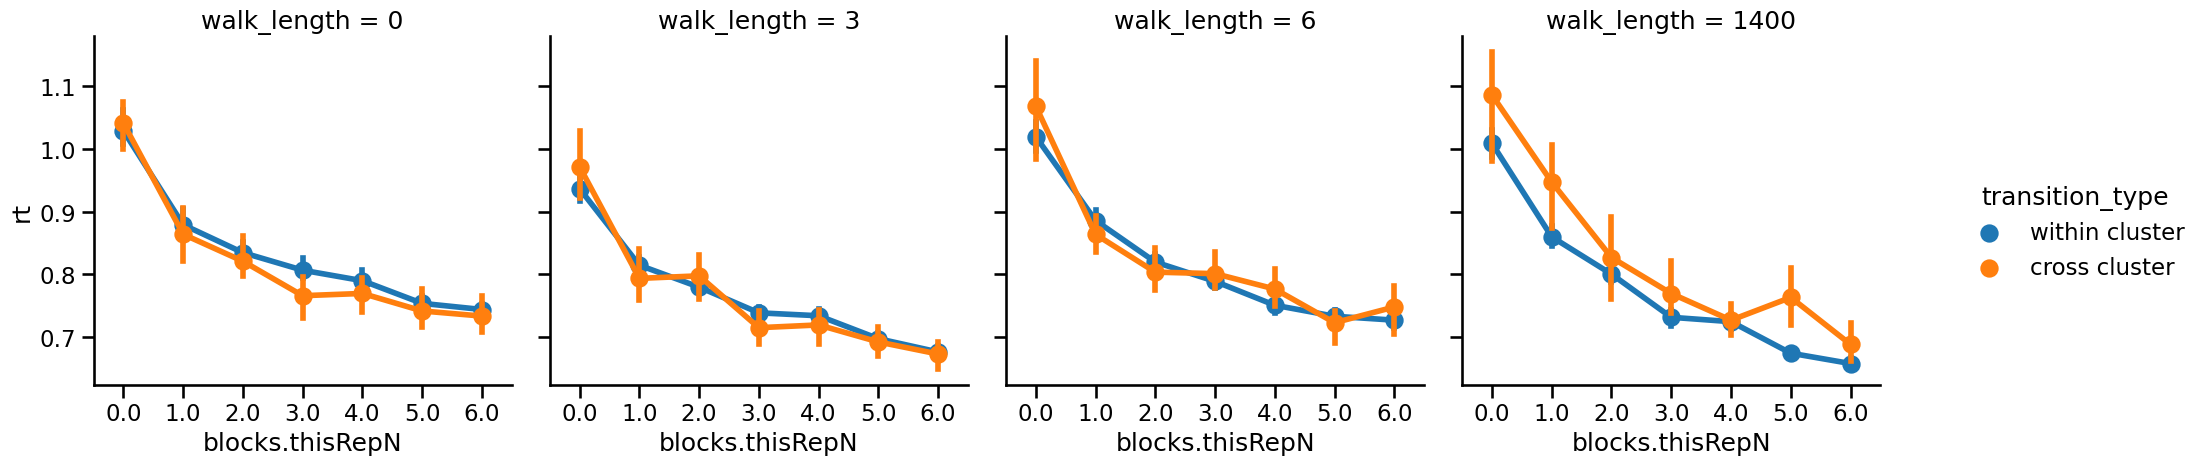

In [51]:
sns.catplot(y = 'rt', 
            x = 'blocks.thisRepN', col = 'walk_length', hue = 'transition_type',
            row_order=['Non Boundary', 'Boundary'], margin_titles=True,
            kind = 'point', estimator='median',
            data=df_clean_rt_outlier)


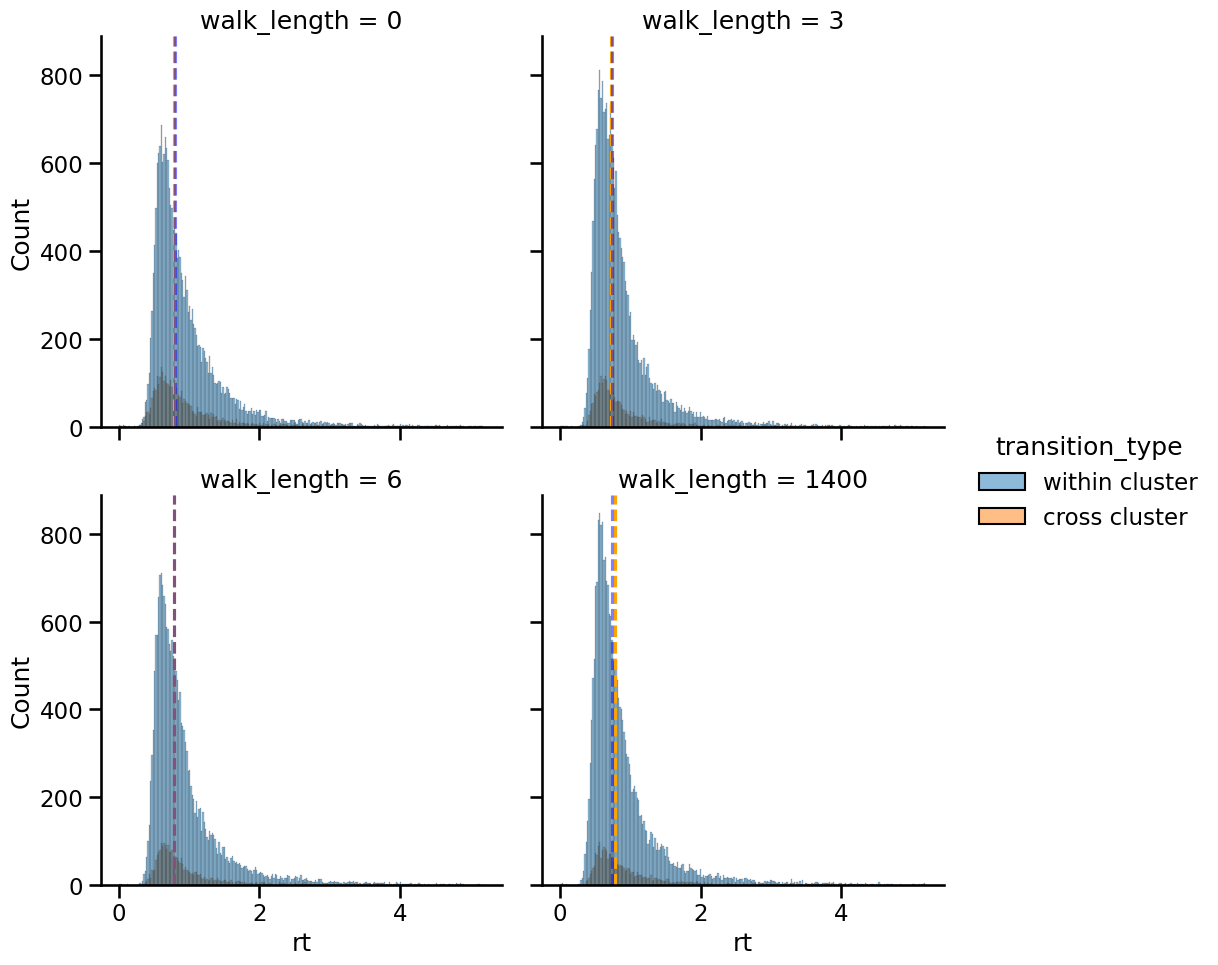

In [53]:
block_cutoff = 0
g = sns.displot(x = 'rt', hue='transition_type', col='walk_length', 
             col_wrap=2, 
             data = df_clean_rt_outlier.loc[df_clean_rt_outlier['blocks.thisRepN'] > block_cutoff])
walk_lengths = [0, 3, 6, 1400]
for i in range(4):
    g.axes[i].axvline(np.nanmedian(df_clean_rt_outlier.loc[((df_clean_rt_outlier['blocks.thisRepN'] > block_cutoff) & (df_clean_rt_outlier['transition_type'] == 'cross cluster') & (df_clean_rt_outlier['walk_length'] == str(walk_lengths[i]))), 'rt']), 
                      c = 'orange', ls = '--', alpha = 1)
    
    g.axes[i].axvline(np.nanmedian(df_clean_rt_outlier.loc[((df_clean_rt_outlier['blocks.thisRepN'] > block_cutoff) & (df_clean_rt_outlier['transition_type'] == 'within cluster') & (df_clean_rt_outlier['walk_length'] == str(walk_lengths[i]))), 'rt']), 
                      c = 'blue', ls = '--', alpha = 0.5)

    # g.axes[0][i].axvline(np.nanmedian(df_clean_rt_outlier.loc[((df_clean_rt_outlier['blocks.thisRepN'] > block_cutoff) & (df_clean_rt_outlier['node_type'] == 'Boundary') & (df_clean_rt_outlier['walk_length'] == walk_lengths[i])), 'rt']), c = 'orange', ls = '--')
    # g.axes[0][i].axvline(np.nanmedian(df_clean_rt_outlier.loc[((df_clean_rt_outlier['blocks.thisRepN'] > block_cutoff) & (df_clean_rt_outlier['node_type'] == 'Non Boundary') & (df_clean_rt_outlier['walk_length'] == walk_lengths[i])), 'rt']), c = 'blue', ls = '--')


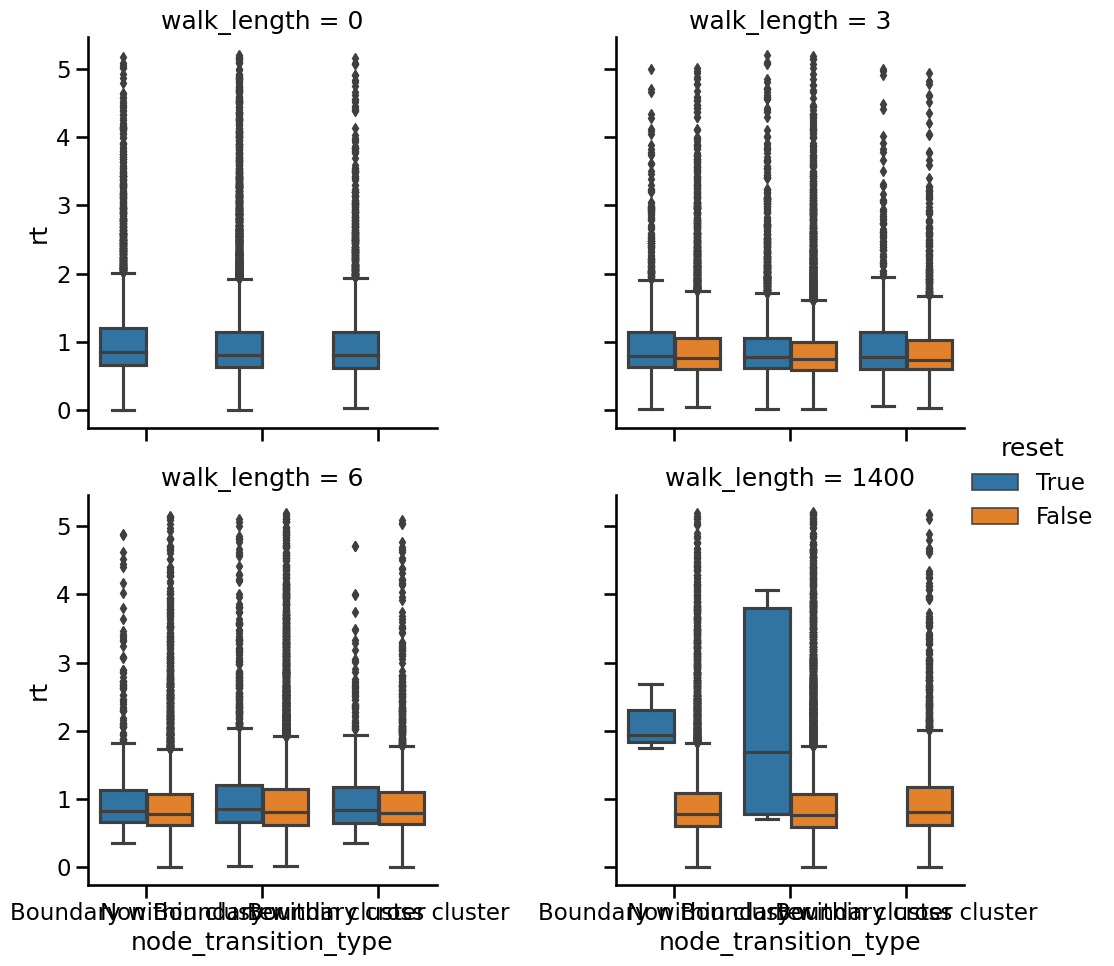

In [54]:
sns.catplot(y = 'rt', 
            hue = 'reset', x = 'node_transition_type', col = 'walk_length', 
            # row_order=['Non Boundary', 'Boundary'], margin_titles=True,
            kind = 'box', estimator='median', col_wrap=2,
            data=df_clean_rt_outlier)


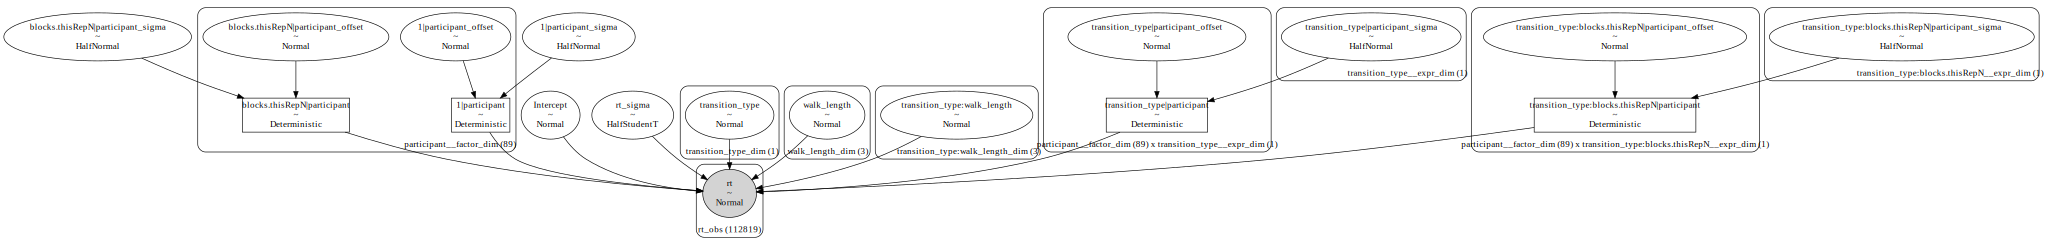

In [55]:
model = bmb.Model("rt ~ (transition_type * blocks.thisRepN|participant) + transition_type * walk_length ", data = df_clean_rt_outlier)
model.build()
model.graph()

In [79]:
sample = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rt_sigma, Intercept, reset, transition_type, hop_length, transition_type:hop_length, 1|participant_sigma, 1|participant_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 668 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


c:\Users\tejas\Anaconda3\envs\eb\lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (58) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot: title={'center': 'Intercept'}>,
        <AxesSubplot: title={'center': 'reset\nTrue'}>,
        <AxesSubplot: title={'center': 'transition_type\nwithin cluster'}>,
        <AxesSubplot: title={'center': 'hop_length\n1400'}>],
       [<AxesSubplot: title={'center': 'hop_length\n3'}>,
        <AxesSubplot: title={'center': 'hop_length\n6'}>,
        <AxesSubplot: title={'center': 'transition_type:hop_length\nwithin cluster, 1400'}>,
        <AxesSubplot: title={'center': 'transition_type:hop_length\nwithin cluster, 3'}>],
       [<AxesSubplot: title={'center': 'transition_type:hop_length\nwithin cluster, 6'}>,
        <AxesSubplot: title={'center': 'rt_sigma'}>,
        <AxesSubplot: title={'center': '1|participant_sigma'}>,
        <AxesSubplot: title={'center': '1|participant\n3000.0'}>],
       [<AxesSubplot: title={'center': '1|participant\n3001.0'}>,
        <AxesSubplot: title={'center': '1|participant\n3002.0'}>,
        <AxesSubplot: title={'center': '1|part

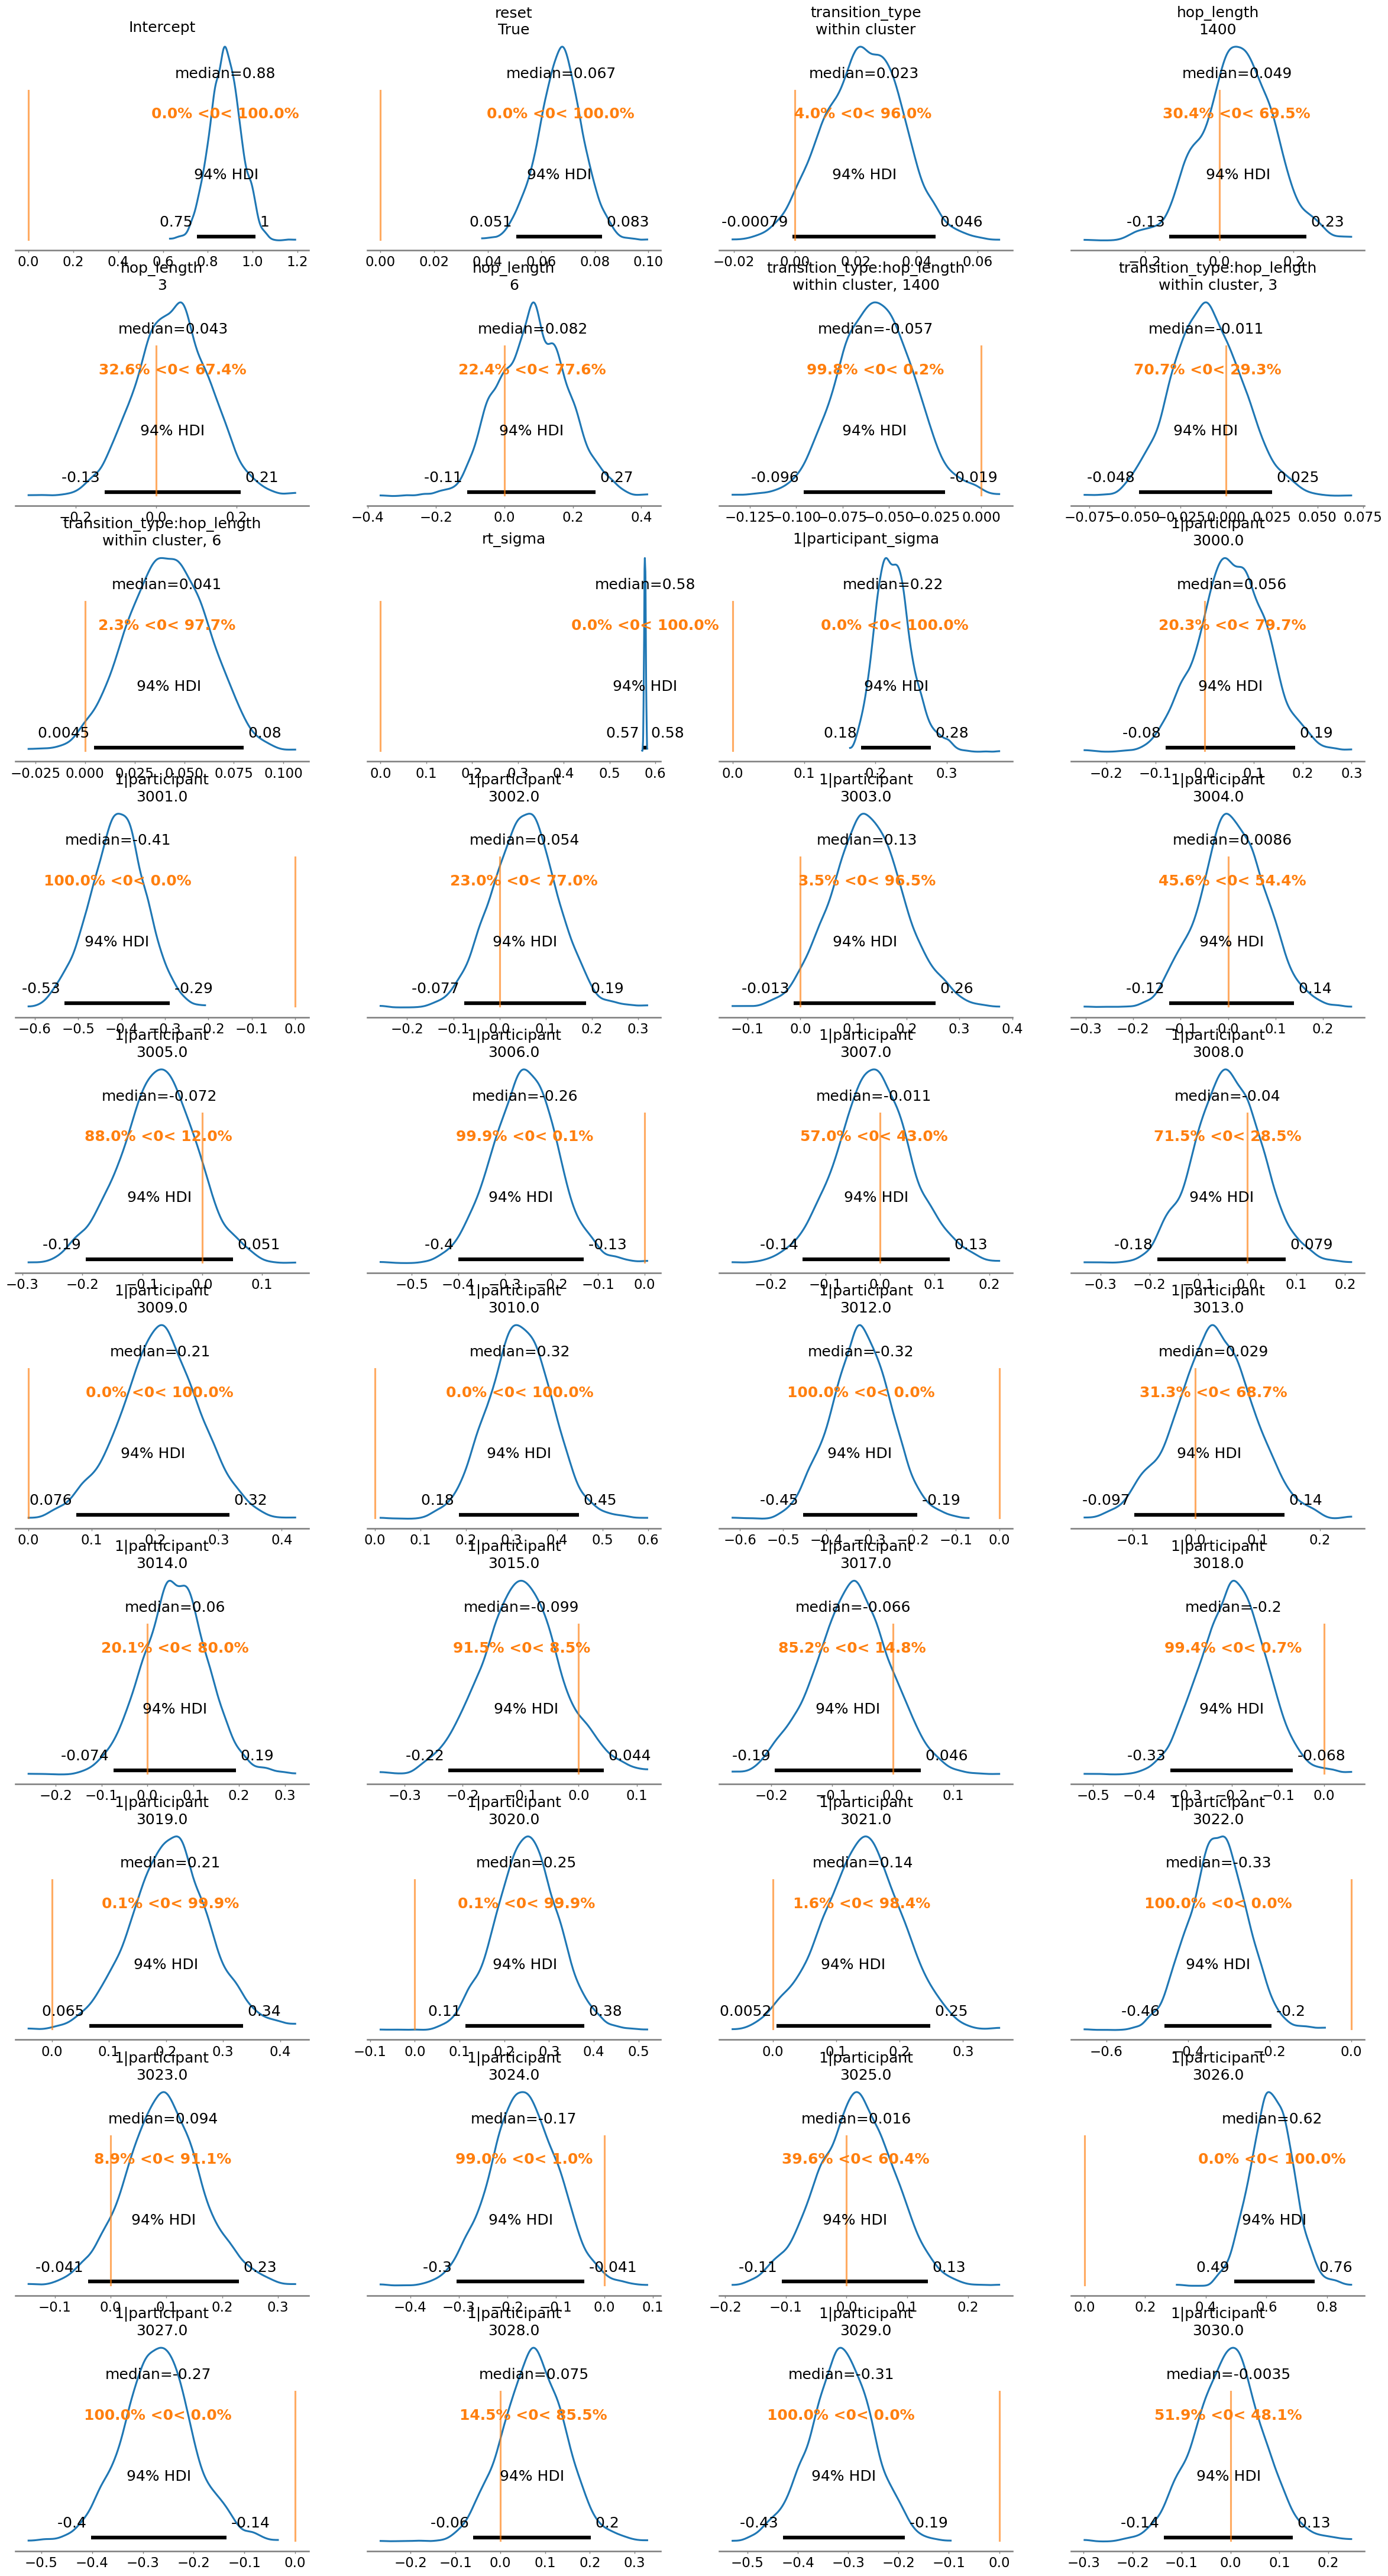

In [80]:
az.plot_posterior(sample, point_estimate='median', ref_val=0)